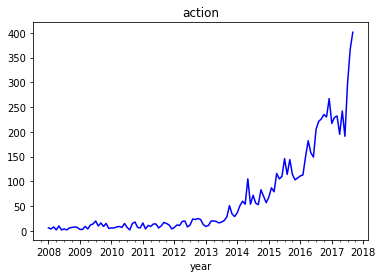

INFO:tensorflow:Restoring parameters from saved/train4
[[[ 497.55023193]
  [ 460.21313477]
  [ 533.38153076]
  [ 569.83831787]
  [ 557.77539062]
  [ 656.887146  ]
  [ 609.46655273]
  [ 659.72454834]
  [ 729.12591553]]]


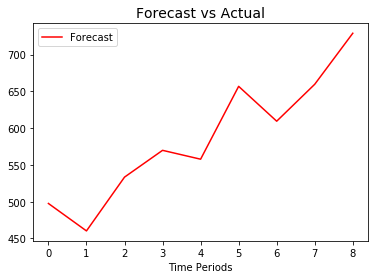

In [78]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

#generate some data
df = pd.read_excel('genre_test.xlsx',index_col='year')
#df 를 입력하면 해당 내용 보여줌
ts = df['action']
ts.plot(c='b',title="action")
plt.show()
#print(len(ts))


TS = np.array(ts)
num_periods = 9
f_horizon = 1 #forecast horizon, one period into the future

x_data = TS[:-num_periods]
x_batches = x_data.reshape(-1,9,1) 

y_data = TS[1:-num_periods+f_horizon]
y_batches = y_data.reshape(-1,9,1)

#print(x_batches.shape)
#print(x_batches[0:2])
#print(x_batches)
#print(y_batches)

#print(y_batches[0:1])
#print(y_batches.shape)


#pull out our test data
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,9,1)
    testY = TS[-(num_periods):].reshape(-1,9,1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods)
#print(X_test.shape)
#print(X_test)

#create Tensorflow graph
tf.reset_default_graph()

num_periods = 9 #number of periods per vector we are using to predict one period ahead
inputs = 1       #number of vectors submitted
hidden = 1500     #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1        #number of output vectors

# 2D tensor를 위한 placeholder로 이곳에 데이터가 채워지게 된다.
# None는 행의 수가 한정되지 않는다는 뜻
# data type를 64bit대신 32bit를 사용하는 이유는 속도를 위해...
X = tf.placeholder(tf.float32, [None,num_periods, inputs])  #create variable objects
y = tf.placeholder(tf.float32, [None,num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden, activation=tf.nn.relu) #create RNN object
#BasicRNNCell, BasicLSTMCell, GRUCell, LSTMCell 4가지 다 사용 가능
rnn_output, states = tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32)  #choose dynamic over static
# cell을 생성한다
# BasicRNNCell 출력의 크기(hidden_size)를 정해준다
# dynamic_rnn을 통해 cell만든 것을 실제로 구동시켜 입력을 주고마지막 state의 값 return 


learning_rate = 0.001 #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])      #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output,output)  #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1,num_periods,output]) #shape of results

#손실 함수 정의
# loss를 adamoptimizer를 통해 최소화 한다.
loss = tf.reduce_sum(tf.square(outputs - y))   #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate) #gradient descent method 
training_op = optimizer.minimize(loss)  #train the result of the application of the cost_function

init = tf.global_variables_initializer()  #initialize all the variables


# implement this model on our training data
epochs = 1000 #number of iterations or training cycles, includes both the FeedFowrd and Backpropogation

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess,"saved/train4")
    """
    #init.run()
    for ep in range(epochs):
        # sampling된 data는 feed_dict인자를 참고해서 placeholder에 공급
        sess.run(training_op, feed_dict = {X: x_batches,y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict = {X: x_batches, y: y_batches})
            print(ep,"\tMSE:",mse)
    """
    for i in range(0,9):
        y_pred = sess.run(outputs, feed_dict = {X: Y_test})
        a = np.array([Y_test[0][1:9]])
        b = np.array(y_pred[0][8])
        Y_test = np.append(a,b).reshape(-1,9,1)
    print(Y_test)
    #save_data = saver.save(sess,"saved/train4")

#check our predicted vs actual
plt.title("Forecast vs Actual", fontsize = 14)
#plt.plot(pd.Series(np.ravel(Y_test)), "b",ls="-" ,label = "Actual")
plt.plot(pd.Series(np.ravel(Y_test)),"r",ls="-",label = "Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

# need for improvement but can be done by changing 
# the number of hidden neurons and/or 
# incresing the number of epochs
